In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-13 17:17:33.531129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 17:17:33.531169: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d-%b-%y')
df = pd.read_csv('../data_priority.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

In [5]:
df1.index[0].strftime('%A'), df2.index[0].strftime('%A'), df3.index[0].strftime('%A')

('Sunday', 'Tuesday', 'Friday')

In [6]:
df1.index[-1].strftime('%A'), df2.index[-1].strftime('%A'), df3.index[-1].strftime('%A')

('Thursday', 'Saturday', 'Tuesday')

### Create batches of training data (12 months)

In [7]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit MLP model 

In [8]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(250, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(250, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=400, verbose=1, callbacks=[callback])
    
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    return model 

In [9]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    model = fit(X, y, n_input, n_output)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_input, 1))
    pred = model.predict(x_input)
    
    mae, rmse, mape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, mape_aux = measure_error(actual, pred[0], n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), mape.append(mape_aux)
        #print(actual[i:i+n_steps_in], pred[0], mae, rmse, mape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input)
    
    return mae, rmse, mape

In [10]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [11]:
def measure_error(actual, pred, step, index):
    #print(actual[index:index+step], pred)
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

2022-10-13 17:17:36.666864: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-13 17:17:36.666914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-13 17:17:36.667339: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/400
16/16 [==============================] - 1s 6ms/step - loss: 3345749.0000
Epoch 2/400
16/16 [==============================] - 0s 5ms/step - loss: 307204.6875
Epoch 3/400
16/16 [==============================] - 0s 6ms/step - loss: 77066.2656
Epoch 4/400
16/16 [==============================] - 0s 5ms/step - loss: 42241.5508
Epoch 5/400
16/16 [==============================] - 0s 5ms/step - loss: 37147.6523
Epoch 6/400
16/16 [==============================] - 0s 5ms/step - loss: 36966.2266
Epoch 7/400
16/16 [==============================] - 0s 5ms/step - loss: 36957.4180
Epoch 8/400
16/16 [==============================] - 0s 5ms/step - loss: 37819.1367
Epoch 9/400
16/16 [==============================] - 0s 5ms/step - loss: 37044.7930
Epoch 10/400
16/16 [==============================] - 0s 5ms/step - loss: 36326.4609
Epoch 11/400
16/16 [==============================] - 0s 5ms/step - loss: 36360.1484
Epoch 12/400
16/16 [==============================] - 0s 4ms/step - los

16/16 [==============================] - 0s 5ms/step - loss: 31266.9277
Epoch 98/400
16/16 [==============================] - 0s 5ms/step - loss: 31013.4414
Epoch 99/400
16/16 [==============================] - 0s 5ms/step - loss: 31053.0371
Epoch 100/400
16/16 [==============================] - 0s 4ms/step - loss: 30322.2988
Epoch 101/400
16/16 [==============================] - 0s 5ms/step - loss: 30979.1719
Epoch 102/400
16/16 [==============================] - 0s 5ms/step - loss: 31764.3516
Epoch 103/400
16/16 [==============================] - 0s 5ms/step - loss: 30887.1719
Epoch 104/400
16/16 [==============================] - 0s 5ms/step - loss: 31974.5801
Epoch 105/400
16/16 [==============================] - 0s 5ms/step - loss: 32614.4395
Epoch 106/400
16/16 [==============================] - 0s 4ms/step - loss: 33240.2812
Epoch 107/400
16/16 [==============================] - 0s 6ms/step - loss: 33306.3164
Epoch 108/400
16/16 [==============================] - 0s 7ms/step - l

16/16 [==============================] - 0s 4ms/step - loss: 30301.3477
Epoch 193/400
16/16 [==============================] - 0s 4ms/step - loss: 29796.8789
Epoch 194/400
16/16 [==============================] - 0s 5ms/step - loss: 30341.6016
Epoch 195/400
16/16 [==============================] - 0s 5ms/step - loss: 29485.5801
Epoch 196/400
16/16 [==============================] - 0s 4ms/step - loss: 29198.3750
Epoch 197/400
16/16 [==============================] - 0s 6ms/step - loss: 31739.3516
Epoch 198/400
16/16 [==============================] - 0s 4ms/step - loss: 30510.9375
Epoch 199/400
16/16 [==============================] - 0s 5ms/step - loss: 32949.3633
Epoch 200/400
16/16 [==============================] - 0s 4ms/step - loss: 30533.2441
Epoch 201/400
16/16 [==============================] - 0s 5ms/step - loss: 29520.7285
Epoch 202/400
16/16 [==============================] - 0s 5ms/step - loss: 29602.4980
Epoch 203/400
16/16 [==============================] - 0s 4ms/step -

16/16 [==============================] - 0s 6ms/step - loss: 29082.2793
Epoch 288/400
16/16 [==============================] - 0s 6ms/step - loss: 30455.3008
Epoch 289/400
16/16 [==============================] - 0s 6ms/step - loss: 29211.3906
Epoch 290/400
16/16 [==============================] - 0s 5ms/step - loss: 28623.6719
Epoch 291/400
16/16 [==============================] - 0s 5ms/step - loss: 30547.7656
Epoch 292/400
16/16 [==============================] - 0s 5ms/step - loss: 29484.6133
Epoch 293/400
16/16 [==============================] - 0s 5ms/step - loss: 28778.4199
Epoch 294/400
16/16 [==============================] - 0s 5ms/step - loss: 28104.7012
Epoch 295/400
16/16 [==============================] - 0s 5ms/step - loss: 28274.1660
Epoch 296/400
16/16 [==============================] - 0s 5ms/step - loss: 30082.2480
Epoch 297/400
16/16 [==============================] - 0s 4ms/step - loss: 31041.5840
Epoch 298/400
16/16 [==============================] - 0s 6ms/step -

16/16 [==============================] - 0s 4ms/step - loss: 27939.9277
Epoch 383/400
16/16 [==============================] - 0s 4ms/step - loss: 29408.8613
Epoch 384/400
16/16 [==============================] - 0s 5ms/step - loss: 30662.3184
Epoch 385/400
16/16 [==============================] - 0s 6ms/step - loss: 30162.5742
Epoch 386/400
16/16 [==============================] - 0s 5ms/step - loss: 28340.7734
Epoch 387/400
16/16 [==============================] - 0s 6ms/step - loss: 28646.4883
Epoch 388/400
16/16 [==============================] - 0s 5ms/step - loss: 28523.0918
Epoch 389/400
16/16 [==============================] - 0s 4ms/step - loss: 29335.9141
Epoch 390/400
16/16 [==============================] - 0s 5ms/step - loss: 27399.7656
Epoch 391/400
16/16 [==============================] - 0s 6ms/step - loss: 28358.7344
Epoch 392/400
16/16 [==============================] - 0s 5ms/step - loss: 27151.4434
Epoch 393/400
16/16 [==============================] - 0s 6ms/step -

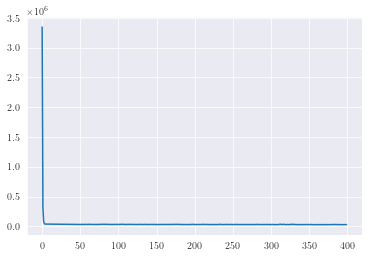

In [12]:
df1 = df1.pivot_table('count', 'date', 'priority')
df1['Total'] = df1.sum(axis=1)
dataset = df1[[1,3,5,8]].values
dataset_total = df1[['Total']].values
mae1, rmse1, smape1 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df1[['Total']][509:].values)

Epoch 1/400
16/16 [==============================] - 1s 6ms/step - loss: 5548355.0000
Epoch 2/400
16/16 [==============================] - 0s 4ms/step - loss: 429255.0312
Epoch 3/400
16/16 [==============================] - 0s 4ms/step - loss: 123778.3516
Epoch 4/400
16/16 [==============================] - 0s 5ms/step - loss: 54908.0703
Epoch 5/400
16/16 [==============================] - 0s 4ms/step - loss: 46692.7656
Epoch 6/400
16/16 [==============================] - 0s 5ms/step - loss: 46131.5039
Epoch 7/400
16/16 [==============================] - 0s 6ms/step - loss: 46244.4844
Epoch 8/400
16/16 [==============================] - 0s 5ms/step - loss: 48464.8477
Epoch 9/400
16/16 [==============================] - 0s 5ms/step - loss: 46920.6367
Epoch 10/400
16/16 [==============================] - 0s 5ms/step - loss: 46061.2891
Epoch 11/400
16/16 [==============================] - 0s 4ms/step - loss: 45301.3555
Epoch 12/400
16/16 [==============================] - 0s 4ms/step - lo

16/16 [==============================] - 0s 4ms/step - loss: 41877.3242
Epoch 98/400
16/16 [==============================] - 0s 4ms/step - loss: 43977.8945
Epoch 99/400
16/16 [==============================] - 0s 4ms/step - loss: 44230.4531
Epoch 100/400
16/16 [==============================] - 0s 4ms/step - loss: 41274.9180
Epoch 101/400
16/16 [==============================] - 0s 4ms/step - loss: 41362.6016
Epoch 102/400
16/16 [==============================] - 0s 4ms/step - loss: 42359.8750
Epoch 103/400
16/16 [==============================] - 0s 4ms/step - loss: 41359.4883
Epoch 104/400
16/16 [==============================] - 0s 4ms/step - loss: 41217.3594
Epoch 105/400
16/16 [==============================] - 0s 4ms/step - loss: 41359.0898
Epoch 106/400
16/16 [==============================] - 0s 5ms/step - loss: 41381.1133
Epoch 107/400
16/16 [==============================] - 0s 5ms/step - loss: 41436.7227
Epoch 108/400
16/16 [==============================] - 0s 6ms/step - l

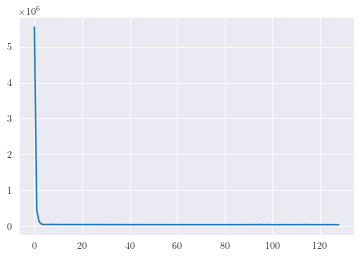

In [13]:
df2 = df2.pivot_table('count', 'date', 'priority')
df2['Total'] = df2.sum(axis=1)
dataset = df2[[1,3,5,8]].values
dataset_total = df2[['Total']].values
mae2, rmse2, smape2 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df2[['Total']][509:].values)

Epoch 1/400
16/16 [==============================] - 1s 4ms/step - loss: 3792215.2500
Epoch 2/400
16/16 [==============================] - 0s 4ms/step - loss: 388323.5938
Epoch 3/400
16/16 [==============================] - 0s 4ms/step - loss: 135721.3281
Epoch 4/400
16/16 [==============================] - 0s 4ms/step - loss: 92779.3359
Epoch 5/400
16/16 [==============================] - 0s 4ms/step - loss: 87411.5703
Epoch 6/400
16/16 [==============================] - 0s 4ms/step - loss: 85638.0938
Epoch 7/400
16/16 [==============================] - 0s 3ms/step - loss: 87445.5078
Epoch 8/400
16/16 [==============================] - 0s 4ms/step - loss: 86412.2266
Epoch 9/400
16/16 [==============================] - 0s 4ms/step - loss: 87667.7656
Epoch 10/400
16/16 [==============================] - 0s 7ms/step - loss: 84114.3828
Epoch 11/400
16/16 [==============================] - 0s 6ms/step - loss: 84050.2266
Epoch 12/400
16/16 [==============================] - 0s 6ms/step - lo

16/16 [==============================] - 0s 6ms/step - loss: 73607.4062
Epoch 98/400
16/16 [==============================] - 0s 4ms/step - loss: 77702.4219
Epoch 99/400
16/16 [==============================] - 0s 4ms/step - loss: 72652.2344
Epoch 100/400
16/16 [==============================] - 0s 5ms/step - loss: 74421.5078
Epoch 101/400
16/16 [==============================] - 0s 8ms/step - loss: 71538.4297
Epoch 102/400
16/16 [==============================] - 0s 6ms/step - loss: 78604.2812
Epoch 103/400
16/16 [==============================] - 0s 4ms/step - loss: 70450.7422
Epoch 104/400
16/16 [==============================] - 0s 4ms/step - loss: 70798.5234
Epoch 105/400
16/16 [==============================] - 0s 7ms/step - loss: 72154.9531
Epoch 106/400
16/16 [==============================] - 0s 5ms/step - loss: 74202.7344
Epoch 107/400
16/16 [==============================] - 0s 5ms/step - loss: 70122.7109
Epoch 108/400
16/16 [==============================] - 0s 4ms/step - l

16/16 [==============================] - 0s 4ms/step - loss: 67650.6094
Epoch 193/400
16/16 [==============================] - 0s 5ms/step - loss: 76731.6797
Epoch 194/400
16/16 [==============================] - 0s 5ms/step - loss: 77627.1641
Epoch 195/400
16/16 [==============================] - 0s 5ms/step - loss: 68075.7656
Epoch 196/400
16/16 [==============================] - 0s 6ms/step - loss: 65617.5234
Epoch 197/400
16/16 [==============================] - 0s 6ms/step - loss: 64648.4023
Epoch 198/400
16/16 [==============================] - 0s 6ms/step - loss: 64988.9102
Epoch 199/400
16/16 [==============================] - 0s 6ms/step - loss: 65303.6289
Epoch 200/400
16/16 [==============================] - 0s 6ms/step - loss: 66174.2344
Epoch 201/400
16/16 [==============================] - 0s 5ms/step - loss: 68723.3672
Epoch 202/400
16/16 [==============================] - 0s 5ms/step - loss: 65671.8594
Epoch 203/400
16/16 [==============================] - 0s 6ms/step -

16/16 [==============================] - 0s 5ms/step - loss: 61912.4805
Epoch 288/400
16/16 [==============================] - 0s 8ms/step - loss: 61907.8984
Epoch 289/400
16/16 [==============================] - 0s 6ms/step - loss: 64605.5781
Epoch 290/400
16/16 [==============================] - 0s 6ms/step - loss: 59307.4883
Epoch 291/400
16/16 [==============================] - 0s 5ms/step - loss: 60732.9219
Epoch 292/400
16/16 [==============================] - 0s 4ms/step - loss: 63243.5000
Epoch 293/400
16/16 [==============================] - 0s 6ms/step - loss: 61677.7266
Epoch 294/400
16/16 [==============================] - 0s 6ms/step - loss: 60799.0469
Epoch 295/400
16/16 [==============================] - 0s 5ms/step - loss: 59002.9727
Epoch 296/400
16/16 [==============================] - 0s 5ms/step - loss: 61393.9961
Epoch 297/400
16/16 [==============================] - 0s 5ms/step - loss: 63140.1133
Epoch 298/400
16/16 [==============================] - 0s 5ms/step -

16/16 [==============================] - 0s 4ms/step - loss: 59614.3828
Epoch 383/400
16/16 [==============================] - 0s 5ms/step - loss: 55855.7266
Epoch 384/400
16/16 [==============================] - 0s 4ms/step - loss: 56559.9062
Epoch 385/400
16/16 [==============================] - 0s 5ms/step - loss: 57088.8828
Epoch 386/400
16/16 [==============================] - 0s 5ms/step - loss: 56586.6172
Epoch 387/400
16/16 [==============================] - 0s 5ms/step - loss: 57038.9141
Epoch 388/400
16/16 [==============================] - 0s 4ms/step - loss: 59230.9023
Epoch 389/400
16/16 [==============================] - 0s 4ms/step - loss: 56481.2891
Epoch 390/400
16/16 [==============================] - 0s 4ms/step - loss: 55577.8789
Epoch 391/400
16/16 [==============================] - 0s 5ms/step - loss: 62057.4570
Epoch 392/400
16/16 [==============================] - 0s 5ms/step - loss: 57029.4766
Epoch 393/400
16/16 [==============================] - 0s 5ms/step -

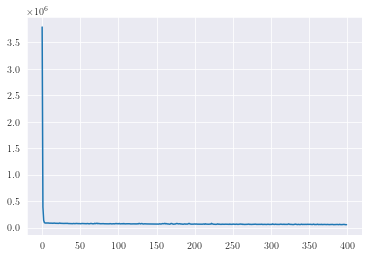

In [14]:
df3 = df3.pivot_table('count', 'date', 'priority')
df3['Total'] = df3.sum(axis=1)
dataset = df3[[1,3,5,8]].values
dataset_total = df3[['Total']].values
mae3, rmse3, smape3 = train_predict(dataset[:509], dataset_total[:509], dataset[509:], df3[['Total']][509:].values)

In [15]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

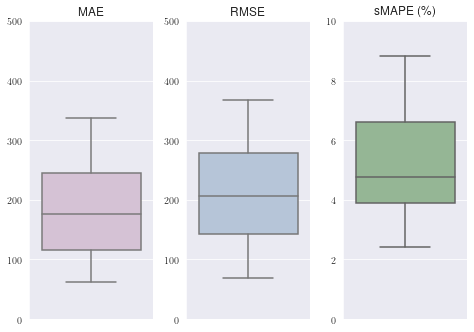

In [16]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
#plt.savefig('figures/emergencies_MLP_daily_priority_boxplot.pdf')

In [18]:
emer_mlp_day_priority = [mae,rmse,smape]
%store emer_mlp_day_priority

Stored 'emer_mlp_day_priority' (list)
